# Portland Case Study

In November 2022, voters in Portland, Oregon approved an overhaul to their system of election.
Previously, Portland had a commission model, with four councillors elected at-large, plus the mayor
as a member of the council. In that system, candidates ran for numbered seats—for instance "City
Commissioner Position 4"—for which the whole city voted. The new system holds the mayor separate and expands to 12 seats, with four geographical districts electing three councillors each through ranked-choice voting.

The precise system of election now in place is called STV or "single transferable vote"; support
from roughly a quarter of the district’s voters is the threshold required for election. Voters can rank
up to six candidates, and rounds of tabulation are conducted with support transferring down the
ballot until three candidates cross the threshold.

The Data and Democracy Lab released a report studying the election, in particular the mechanics of the STV election to explain that the voting system played a direct role in securing such strong representation for communities of color. You can read the report [here.](https://mggg.org/ppm)
In this tutorial notebook, we show how VoteKit can be used to replicate the analysis done in the report. For a more thorough replication repository, you can visit [this GitHub repo.](https://github.com/mggg/Portland-Postmortem)

## Cast Vote Record (CVR)

The city of Portland released the cast vote record (CVR) for the election in a format that reflected the scantron style ballot. Each voter was given a row in a table, and each candidate was given 6 columns, one for each ranking position. A vote for a candidate in position i was recorded as a 1 in that candidate's "Ranking i" column, and 0 otherwise. This allows for the possiblity of overvotes---multiple candidates can have a 1 in their "Ranking i" column--- and skips---no candidate has a 1 in their "Ranking i" column. In order to make this format readable by VoteKit, we need to transform it so that there are only 6 columns total. Each column represents one position of a ranking, and the entry of that column is the candidate ranked in that position. 

In addition to this format, the city also released the data by district, but included every voter from the entire city in each data set. So we will have to scrub the voters that are from the other 3 districts.

If you want to skip all of the cleaning steps below, you can download the prepared data [here](https://github.com/mggg/VoteKit/blob/main/notebooks/Portland_D1_cleaned_votekit_pref_profile.pkl). Save the pkl file in the same working directory as your Python notebook.

## Cleaning the data and analyzing voter errors

First, we will read in the csv of the cast vote record, scrub the non-district 1 voters, and create new columns that match the format needed by VoteKit. The csv is too large to be stored in GitHub, so [here is a link.](https://multco.us/info/turnout-and-statistics-november-2024-general-election) You will want the "Councilor District 1 Cast Vote Record Data". Alternatively, we can use a package called ``gdown`` to download the data from the Google Drive folder that Portland stored it in.

After that, we will use VoteKit to perform the rest of the cleaning.

In [1]:
import pandas as pd
import gdown

file_id = "1ly3IcjeQTpet-zvxd49DM_OmY_i4uftB"
url = f"https://drive.google.com/uc?id={file_id}"
save_to = "Portland_D1_raw_from_city.csv"

gdown.download(url, save_to, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ly3IcjeQTpet-zvxd49DM_OmY_i4uftB
To: /Users/cdonnay/Documents/GitHub/MGGG/VoteKit/notebooks/Portland_D1_raw_from_city.csv
100%|██████████| 104M/104M [00:15<00:00, 6.58MB/s] 


'Portland_D1_raw_from_city.csv'

In [2]:
D1_df = pd.read_csv(save_to) 
# D1_df = pd.read_csv("file_name.csv") # if you downloaded the file directly, uncomment this and insert the file name
D1_df.head()

,RowNumber,BoxID,BoxPosition,BallotID,PrecinctID,BallotStyleID,PrecinctStyleName,ScanComputerName,Status,Remade,...,"Choice_122_1:City of Portland, Councilor, District 1:3:Number of Winners 3:Write-in-122:NON","Choice_122_1:City of Portland, Councilor, District 1:4:Number of Winners 3:Write-in-122:NON","Choice_122_1:City of Portland, Councilor, District 1:5:Number of Winners 3:Write-in-122:NON","Choice_122_1:City of Portland, Councilor, District 1:6:Number of Winners 3:Write-in-122:NON","Choice_50003_1:City of Portland, Councilor, District 1:1:Number of Winners 3:Uncertified Write In:NON","Choice_50003_1:City of Portland, Councilor, District 1:2:Number of Winners 3:Uncertified Write In:NON","Choice_50003_1:City of Portland, Councilor, District 1:3:Number of Winners 3:Uncertified Write In:NON","Choice_50003_1:City of Portland, Councilor, District 1:4:Number of Winners 3:Uncertified Write In:NON","Choice_50003_1:City of Portland, Councilor, District 1:5:Number of Winners 3:Uncertified Write In:NON","Choice_50003_1:City of Portland, Councilor, District 1:6:Number of Winners 3:Uncertified Write In:NON"
0,1,RCV-0001,1,RCV-0001+10003,26,3,4506-1,ScanStation6,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,RCV-0001,2,RCV-0001+10005,32,1,2804-1,ScanStation6,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,RCV-0001,3,RCV-0001+10007,53,1,3303-1,ScanStation6,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,RCV-0001,4,RCV-0001+10009,22,1,4105-1,ScanStation6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,RCV-0001,5,RCV-0001+10011,53,1,3303-1,ScanStation6,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# stores all columns that have ranking information
rank_columns = {i:[col for col in D1_df.columns if f'{i}:Number' in col] for i in range(1,7)}
all_rank_cols = [col for col_list in rank_columns.values() for col in col_list]

The code below scrubs any voter who did not cast at least one vote, which in turn removes any voter not from district 1.

In [4]:
D1_voters_df = D1_df[D1_df[all_rank_cols].sum(axis=1) > 0].reset_index(drop=True) # just resets the index of the df

We now add the new ranking columns that match the VoteKit format.

In the process, we will lose some information about overvotes, when voters put more than one candidate in a ranking.

In [5]:
ranking_data = {i:[-1 for _ in range(len(D1_voters_df))] for i in range(1,7)}

for voter_index, row in D1_voters_df.iterrows():
    for rank_position in range(1,7):
        num_votes_cast = row[rank_columns[rank_position]].sum()

        if num_votes_cast == 0:
            cast_vote = ""
        
        elif num_votes_cast > 1:
            cast_vote = "overvote"

            # here we lost knowledge of who was in the overvote. That's how Portland runs their election
            # system, but it could be interesting to study who is in the overvote!

        else:
            # find candidate name from column
            pd_series = row[rank_columns[rank_position]]
            cast_vote_column_name = pd_series.loc[pd_series == 1].index.tolist()[0]
            cast_vote = cast_vote_column_name.split(":")[-2]

        ranking_data[rank_position][voter_index] = cast_vote 

# add the new columns
for rank_position in range(1,7):
    D1_voters_df[f"Rank {rank_position}"] = ranking_data[rank_position]

In [6]:
D1_voters_df.head()

,RowNumber,BoxID,BoxPosition,BallotID,PrecinctID,BallotStyleID,PrecinctStyleName,ScanComputerName,Status,Remade,...,"Choice_50003_1:City of Portland, Councilor, District 1:3:Number of Winners 3:Uncertified Write In:NON","Choice_50003_1:City of Portland, Councilor, District 1:4:Number of Winners 3:Uncertified Write In:NON","Choice_50003_1:City of Portland, Councilor, District 1:5:Number of Winners 3:Uncertified Write In:NON","Choice_50003_1:City of Portland, Councilor, District 1:6:Number of Winners 3:Uncertified Write In:NON",Rank 1,Rank 2,Rank 3,Rank 4,Rank 5,Rank 6
0,54,RCV-0001,54,RCV-0001+10109,35,2,4703-1,ScanStation6,0,0,...,0,0,0,0,Terrence Hayes,Loretta Smith,Noah Ernst,,,
1,58,RCV-0001,58,RCV-0001+10117,20,2,4508-1,ScanStation6,0,0,...,0,0,0,0,Loretta Smith,Steph Routh,Timur Ender,David Linn,Candace Avalos,Jamie Dunphy
2,59,RCV-0001,59,RCV-0001+10119,20,2,4508-1,ScanStation6,0,0,...,0,0,0,0,Loretta Smith,Steph Routh,Timur Ender,David Linn,Candace Avalos,Jamie Dunphy
3,124,RCV-0001,124,RCV-0001+10249,9,2,4802-1,ScanStation6,0,0,...,0,0,0,0,Michael (Mike) Sands,Doug Clove,Joe Furi,Timur Ender,Deian Salazar,Loretta Smith
4,199,RCV-0002,11,RCV-0002+10023,39,2,4707-1,ScanStation8,0,0,...,0,0,0,0,Timur Ender,Candace Avalos,Cayle Tern,Steph Routh,Michael (Mike) Sands,Jamie Dunphy


In [7]:
D1_voters_df[[f"Rank {rank_position}" for rank_position in range(1,7)]].to_csv("Portland_D1_raw_votekit_format.csv")

Now that the csv is in the correct format for VoteKit, we can complete our cleaning using VoteKit's built in cleaning tools.

In [8]:
from votekit.cvr_loaders import load_csv

profile = load_csv("Portland_D1_raw_votekit_format.csv", rank_cols=[1,2,3,4,5,6])

In [9]:
profile

Profile contains rankings: True
Maximum ranking length: 6
Profile contains scores: False
Candidates: ('Candace Avalos', 'Cayle Tern', 'Jamie Dunphy', 'Loretta Smith', 'Steph Routh', 'Doug Clove', 'Michael (Mike) Sands', 'David Linn', 'Timur Ender', 'Deian Salazar', 'Peggy Sue Owens', 'Joe Allen', 'Joe Furi', 'Terrence Hayes', 'Noah Ernst', 'Thomas Shervey', 'Uncertified Write In', 'Write-in-121', 'Write-in-122', 'Write-in-120', 'overvote')
Candidates who received votes: ('Candace Avalos', 'Cayle Tern', 'Jamie Dunphy', 'Loretta Smith', 'Steph Routh', 'Doug Clove', 'Michael (Mike) Sands', 'David Linn', 'Timur Ender', 'Deian Salazar', 'Peggy Sue Owens', 'Joe Allen', 'Joe Furi', 'Terrence Hayes', 'Noah Ernst', 'Thomas Shervey', 'Uncertified Write In', 'Write-in-121', 'Write-in-122', 'Write-in-120', 'overvote')
Total number of Ballot objects: 19933
Total weight of Ballot objects: 43669

Notice above that there is a difference between the number of total ballots and the total weight. This indicates that the profile has been grouped; that is, ballots with the same ranking have been aggregated so that there is one ballot, but with increased weight. We need to be careful and sum the ballot weights, not the number of ballots, if we want to know the total number of voters.

We will take this moment to analyze how many overvotes occurred in first place, as well as how many occurred anywhere on the ballot.

In [10]:
num_ballots_cast = profile.total_ballot_wt

num_overvotes_first_place = sum(b.weight for b in profile.ballots if b.ranking[0] == {"overvote"})
num_ballots_with_overvotes = sum(b.weight for b in profile.ballots if any(cand_set == {"overvote"} for cand_set in b.ranking))

print(f"There were {num_overvotes_first_place} overvotes in first place, or {num_overvotes_first_place/num_ballots_cast:.1%} of the ballots.")
print(f"There were {num_ballots_with_overvotes} ballots with overvotes in any place, or {num_ballots_with_overvotes/num_ballots_cast:.1%} of the ballots.")

There were 906 overvotes in first place, or 2.1% of the ballots.
There were 1474 ballots with overvotes in any place, or 3.4% of the ballots.


In the rules of Portland's election, which you can find [here](), any skipped positions and overvotes are ignored by the STV algorithm, and any candidates that were ranked below the position are moved up. The same thing occurs to three of the write in categories, but oddly enough, not to the "Uncertified Write-in" category.

While Portland did not alter the ballots themselves, but rather told the STV algorithm how to ignore ballot errors, this is mathematically equvalent to pre-processing the ballots. VoteKit's ``remove_and_condense`` function removes candidates and then condenses any ballot positions left empty after scrubbing the given candidates.

We will take this moment to also analyze spoilage. We call a ballot "spoiled" if it is removed during the cleaning process. We will record the percentage of ballots that are spoiled.

In [11]:
from votekit.cleaning import remove_and_condense

profile = remove_and_condense("overvote", profile)

num_ballots_spoiled_by_ov_skips = num_ballots_cast - profile.total_ballot_wt 
print(f"{num_ballots_spoiled_by_ov_skips} ballots, or {num_ballots_spoiled_by_ov_skips/num_ballots_cast:.1%} of all ballots, were spoiled by overvotes or skips in D1.")

profile = remove_and_condense(['Write-in-120', 'Write-in-121', 'Write-in-122'], profile)

num_ballots_scrubbed_by_wi = num_ballots_cast - num_ballots_spoiled_by_ov_skips-profile.total_ballot_wt 
print(f"{num_ballots_scrubbed_by_wi} ballots, or {num_ballots_scrubbed_by_wi/num_ballots_cast:.1%} of all ballots, were scrubbed by write ins in D1.")

712 ballots, or 1.6% of all ballots, were spoiled by overvotes or skips in D1.
86 ballots, or 0.2% of all ballots, were scrubbed by write ins in D1.


We also have to handle one more item of cleaning. It is entirely possible that a voter listed the same candidate more than once on their ballot, which is not allowed. Portland chose to keep the first occurrence, and ignore any later occurrences, condensing any positions left empty as a result.

In [12]:
from votekit.cleaning import remove_repeated_candidates, condense_profile

profile = condense_profile(remove_repeated_candidates(profile))

Now to compute the adjusted and tabulated rate, which is the percentage of ballots that were touched by a cleaning rule but still used in the final tabulation.
To do this we use the ``CleanedProfile`` class, which keeps track of the previous profile before a cleaning step, as well as which ballots were altered along the way.

In [13]:
def find_all_parents(profile):
    """
    Find all of the parent profiles of a CleanedProfile. 
    Returns a list, where the first entry is the input profile, and the last entry is the original
    pre-cleaned profile.
    """
    if hasattr(profile, "parent_profile"):
        return [profile] + find_all_parents(profile.parent_profile)
    
    return [profile]

def adjusted_and_tabulated(profile):
    """
    Compute the number of ballots that were adjusted by a cleaning rule but eventually used in the
    tabulation.
    """ 
    adj_idxs = set().union(*[p.nonempty_altr_idxs for p in find_all_parents(profile)[:-1]])

    adj_and_tab_idxs = list(adj_idxs.intersection(profile.df.index))

    return sum(profile.df.loc[adj_and_tab_idxs, "Weight"])


num_adj_and_tabulated = adjusted_and_tabulated(profile)
print(f"{num_adj_and_tabulated} ballots, or {num_adj_and_tabulated/num_ballots_cast:.2%} of all ballots, were adjusted before tabulation in D1.")

2507 ballots, or 5.74% of all ballots, were adjusted before tabulation in D1.


Finally, the profile is cleaned and we can save it for analysis. We save it as a pickle file, which is a way of storing Python variables.

In [14]:
profile.to_pickle("Portland_D1_cleaned_votekit_pref_profile.pkl")
print(f"After cleaning, there are now {profile.total_ballot_wt:,} ballots.")

After cleaning, there are now 42,871 ballots.


## Analysis

Finally, we have a CVR that is cleaned and ready to be analyzed. If youskipped all of the cleaning steps above, you can download the prepared data [here](https://github.com/mggg/VoteKit/blob/main/notebooks/Portland_D1_cleaned_votekit_pref_profile.pkl). Save the pkl file in the same working directory as your Python notebook.

The first thing we should do is verify that our data and outcome matches that of the official election.

In [15]:
from votekit.pref_profile import PreferenceProfile

profile = PreferenceProfile.from_pickle("Portland_D1_cleaned_votekit_pref_profile.pkl")

Do we have the correct candidates? Do we have the same vote totals? Do we get the same STV winner set? In district 1, Avalos, Dunphy, and Smith were elected. The winners, first place vote distribution, and lots of other stats we can double check, are given [here](https://www.portland.gov/sites/default/files/2024/Portland-District-1-Certified-Abstract-Nov-2024.pdf).

In [16]:
from votekit.elections import STV
from votekit.utils import first_place_votes


# 3 seat election
election = STV(profile, m=3)
print("Winners in order of election")
i=0
for cand_set in election.get_elected():
    for cand in cand_set:
        i+=1
        print(i, cand)

# threshold
print("\nThreshold: ", election.threshold, "\n")

fpv_dict = first_place_votes(profile)
cands_sorted_by_fpv = sorted(zip(fpv_dict.keys(), fpv_dict.values()), # creates a list of tuples, (name, fpv)
                                reverse=True,  #decreasing order
                                key = lambda x: x[1], # sort by second element of tuple, which is fpv)
                                    )

print("Candidates in decreasing order of first place votes.\n")
for cand, fpv in cands_sorted_by_fpv:
    print(cand, fpv)

Winners in order of election
1 Candace Avalos
2 Loretta Smith
3 Jamie Dunphy

Threshold:  10718 

Candidates in decreasing order of first place votes.

Candace Avalos 8297
Loretta Smith 5586
Jamie Dunphy 5064
Noah Ernst 4052
Terrence Hayes 3975
Steph Routh 3894
Timur Ender 3550
Doug Clove 1698
Peggy Sue Owens 1266
David Linn 1111
Joe Allen 978
Michael (Mike) Sands 952
Deian Salazar 720
Cayle Tern 711
Thomas Shervey 385
Joe Furi 355
Uncertified Write In 277


Take a moment to verify these against the [official record](https://www.portland.gov/sites/default/files/2024/Portland-District-1-Certified-Abstract-Nov-2024.pdf).

## Candidate Statistics

### Viable Candidates

Portland had a LOT of candidates running. District 1 had 16 named candidates and a handful of write ins.

We choose to categorize the candidates as viable and non-viable in order to focus the scale of our analysis. A viable candidate is one that received at least as many mentions as the STV threshold. We call them viable because this is a necessary condition to win. 

(Well, technically it is possible for a non-viable candidate to win by being the last person standing after eliminations, but it is an edge case and does not occur in Portland. Only viable candidates win across all four districts.)

First, let's plot the candidate mentions, along with the threshold for election.

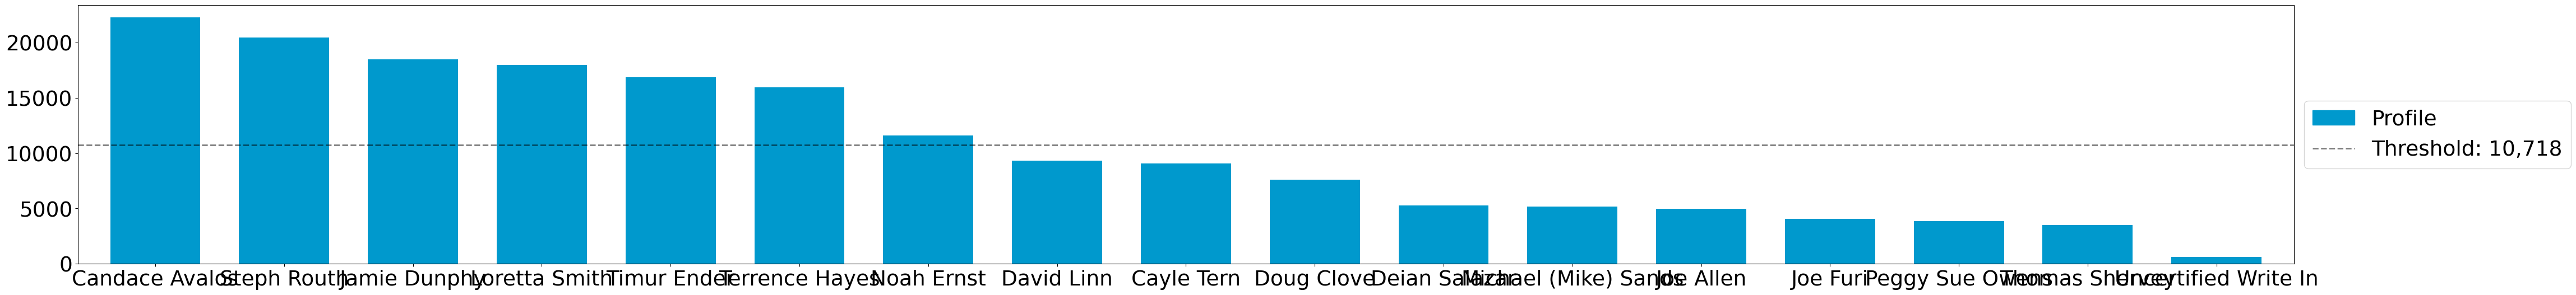

In [17]:
from votekit.plots import profile_mentions_plot

ax = profile_mentions_plot(profile, 
                            threshold_values=election.threshold, 
                            threshold_kwds={"label": f"Threshold: {election.threshold:,}", 
                                        "color":"black", 
                                        "linestyle": "--"},
                            show_profile_legend=True)

Well the candidate names are too long to fit on the axis, so let's relabel them.

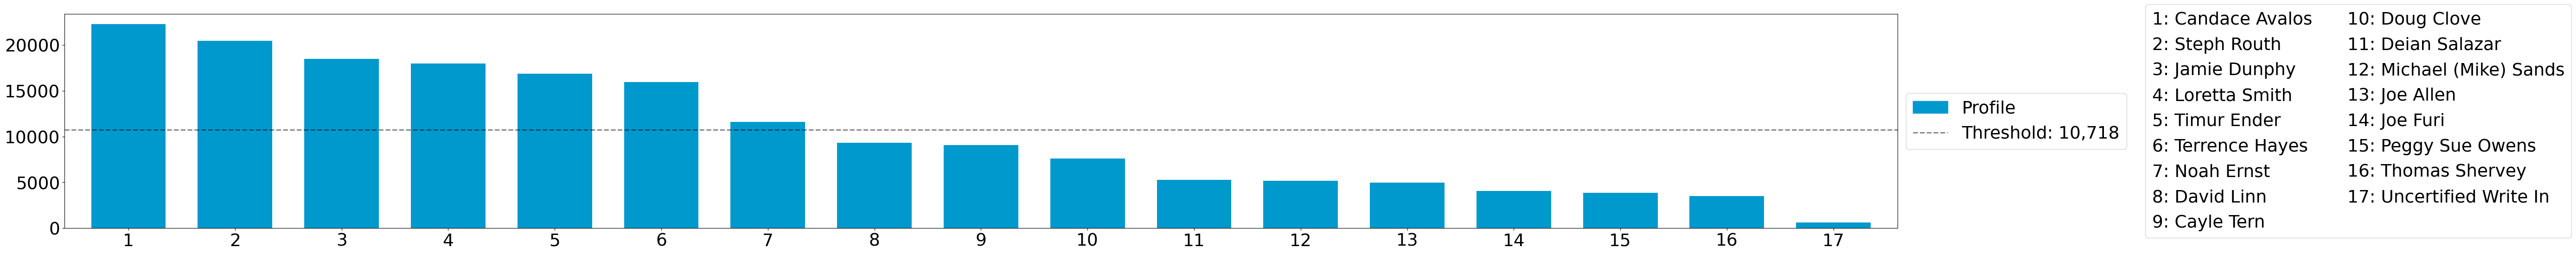

In [18]:
ax = profile_mentions_plot(profile, 
                            threshold_values=election.threshold, 
                            threshold_kwds={"label": f"Threshold: {election.threshold:,}", 
                                        "color":"black", 
                                        "linestyle": "--"},
                            show_profile_legend=True,
                            relabel_candidates_with_int=True)

We now see visually who is viable: Avalos, Routh, Dunphy, Smith, Ender, Hayes, and Ernst.

To determine the viable candidates Pythonically, you can do the following.

In [19]:
from votekit.utils import mentions

mentions_dict = mentions(profile)
viable_cands = [c for c, mentions in mentions_dict.items() if mentions >= election.threshold]

viable_cands = sorted(viable_cands, reverse=True, key = lambda x: mentions_dict[x])
print("Viable candidates in decreasing order of mentions")

for i, cand in enumerate(viable_cands):
    print(i+1, cand)

Viable candidates in decreasing order of mentions
1 Candace Avalos
2 Steph Routh
3 Jamie Dunphy
4 Loretta Smith
5 Timur Ender
6 Terrence Hayes
7 Noah Ernst


Let's also plot their first place votes, next to their mentions. After all, STV is based on first place votes, and this can help explain the winner set we observe. To make a plot this customized, we have to do a bit more work and expose the underlying function that `profile_mentions_plot` is a wrapper for.

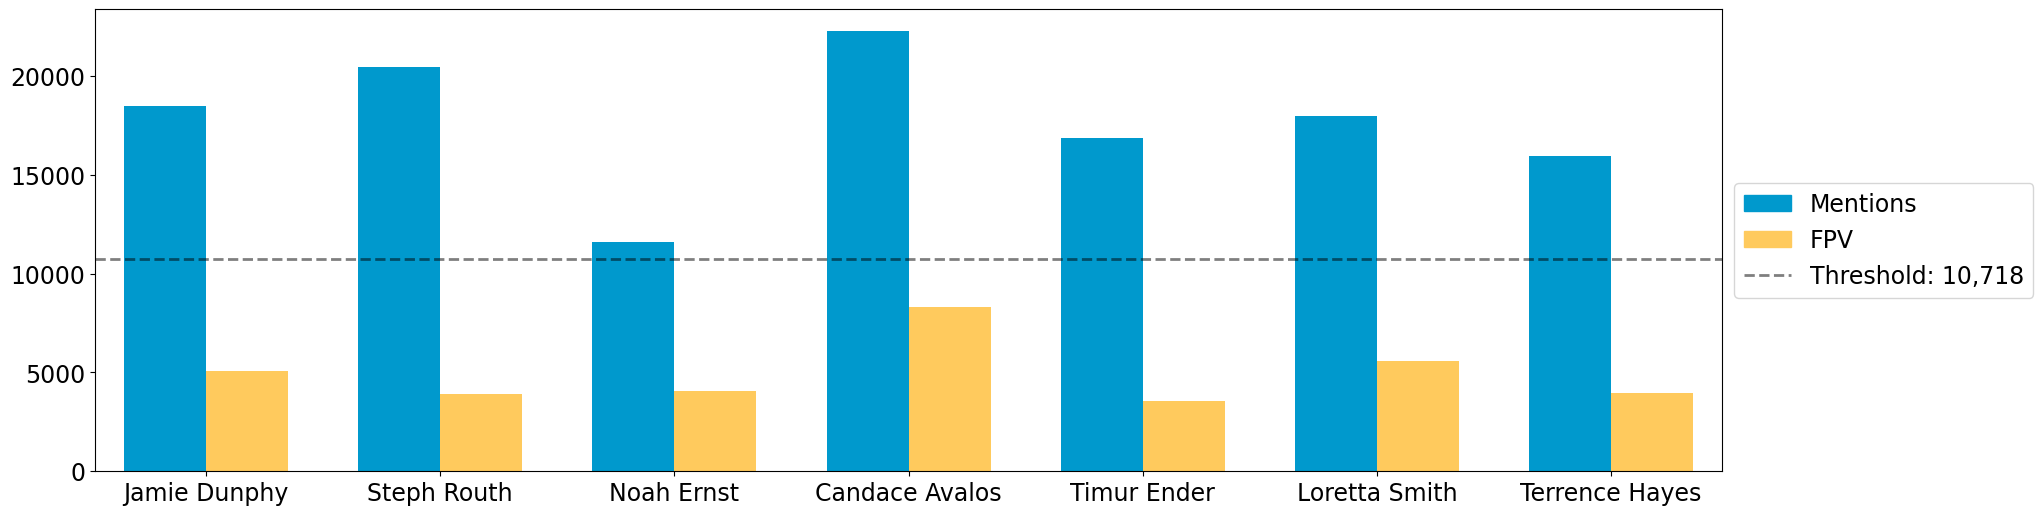

In [20]:
from votekit.plots import multi_bar_plot

viable_cands_mentions = {cand:mentions for cand, mentions in mentions_dict.items() if cand in viable_cands}
viable_cands_fpv = {cand: fpv for cand, fpv in first_place_votes(profile).items() if cand in viable_cands}

ax = multi_bar_plot({"Mentions": viable_cands_mentions, "FPV": viable_cands_fpv},  
                            threshold_values=election.threshold, 
                            threshold_kwds={"label": f"Threshold: {election.threshold:,}", 
                                        "color":"black", 
                                        "linestyle": "--"},
                    )

Whoops, the candidates are not in our desired order. This is also easy to fix by adding the `candidate_ordering` parameter.

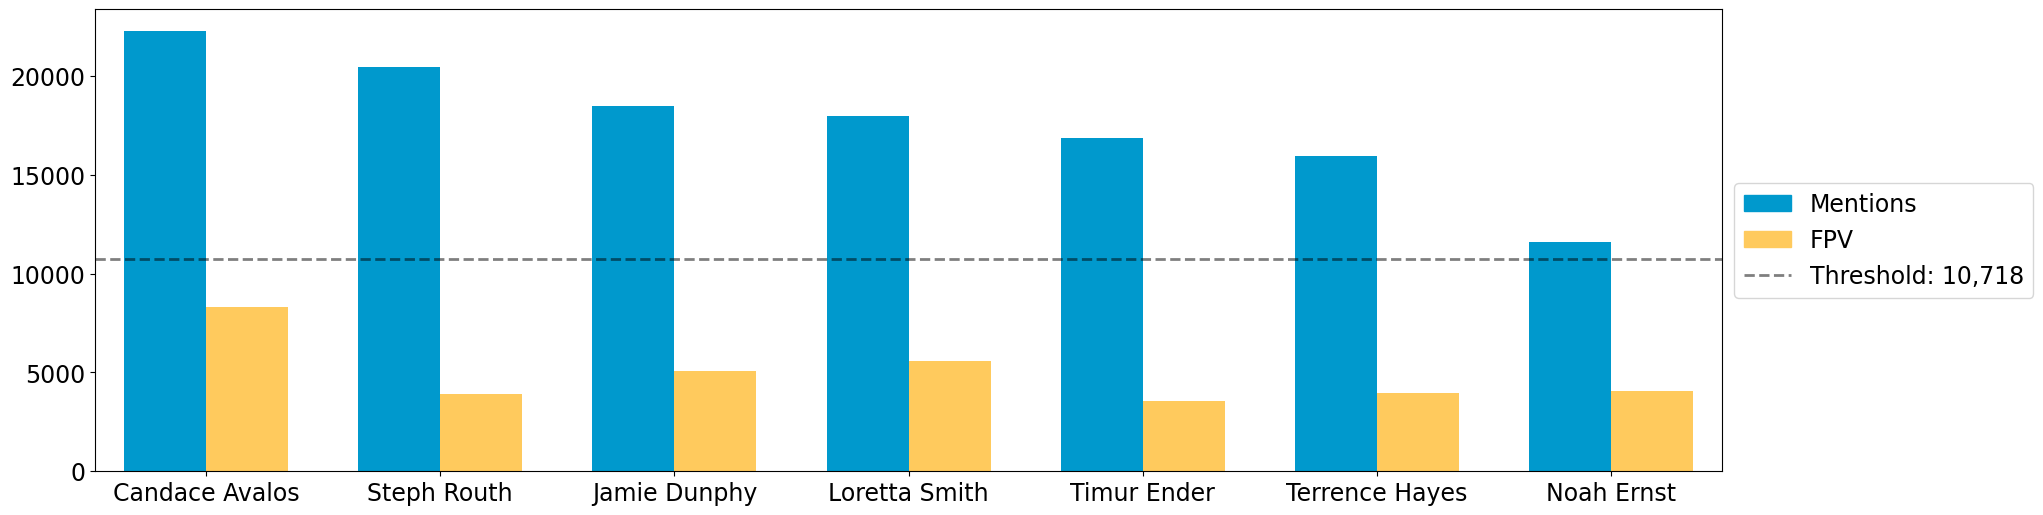

In [21]:
ax = multi_bar_plot({"Mentions": viable_cands_mentions, "FPV": viable_cands_fpv},
                    category_ordering = viable_cands,
                    threshold_values=election.threshold, 
                    threshold_kwds={"label": f"Threshold: {election.threshold:,}", 
                                        "color":"black", 
                                        "linestyle": "--"},
)

We see that part of the reason Routh was not elected is that he has significantly less FPV support than Dunphy and Smith, who were elected.

### Dominating Tiers

A dominating tier of candidates is a set of candidates that beat all other candidates in lower tiers in head to head comparisons.
If there is a unique member of the highest tier, i.e. a candidate that beats all other candidates head to head, they are called the Condorcet winner, or Condorcet candidate.

In Portland, all four districts have Condorcet candidates—and in fact all four districts have a
Condorcet order on their viable candidates. Interestingly, District 3 also contains what is known as a Condorcet cycle: three non-viable candidates (Knab, Wanner, Azul Otero) receive conflicting head-to-head support from voters.
Wanner is preferred to Knab 18,021 to 17,658; Knab is preferred to Azul Otero 16,415 to 12,225; but Azul Otero is narrowly
preferred to Wanner, 18,602 to 18,289.

To compute dominating tiers, we do the following.

In [22]:
from votekit.graphs import PairwiseComparisonGraph

pwcg = PairwiseComparisonGraph(profile)
dominating_tiers = pwcg.get_dominating_tiers()

print("The dominating tiers are: ")
for tier in dominating_tiers:
    print(tier)

if pwcg.has_condorcet_winner():
    print(f"\nThe Condorcet candidate is: {next(iter(dominating_tiers[0]))}")
else:
    print(f"\n There is no unique Condorcet winner. The top tier is {dominating_tiers[0]}")

The dominating tiers are: 
{'Candace Avalos'}
{'Steph Routh'}
{'Jamie Dunphy'}
{'Loretta Smith'}
{'Timur Ender'}
{'Terrence Hayes'}
{'Noah Ernst'}
{'Cayle Tern'}
{'David Linn'}
{'Doug Clove'}
{'Michael (Mike) Sands'}
{'Deian Salazar'}
{'Joe Allen'}
{'Joe Furi'}
{'Peggy Sue Owens'}
{'Thomas Shervey'}
{'Uncertified Write In'}

The Condorcet candidate is: Candace Avalos


### Candidate Similarity

Finally, we can plot a collection of matrices that tell us something about the relationship between candidates. The three kinds of matrices are: boost, candidate distance, and comentions. 

The (i,j) entry of the boost matrix shows P(mention i | mention j) - P(mention i). Thus, the i,j entry shows the boost given to candidate i by candidate j.

In [23]:
from votekit.matrices import matrix_heatmap, boost_matrix, candidate_distance_matrix, comentions_matrix

all_cands_sorted_by_mentions = sorted(profile.candidates, reverse=True, key = lambda x: mentions_dict[x])

# computes the matrix
bm  = boost_matrix(profile, candidates = all_cands_sorted_by_mentions)

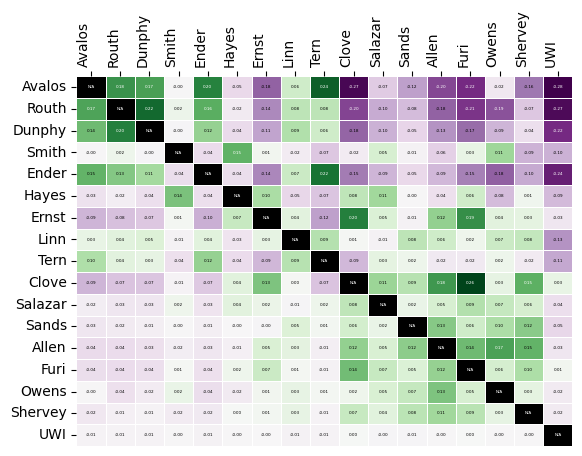

In [24]:
all_last_names = [name.split(" ")[-1] if "Write In" not in name 
                                        else "UWI" 
                                        for name in all_cands_sorted_by_mentions]

# plots the matrix
ax  = matrix_heatmap(bm, row_labels=all_last_names, 
                        column_labels=all_last_names,
                        row_label_rotation = 0,
                        column_label_rotation = 90)

Since there are so many candidates, we should adjust the figure size and maybe the font size as well.

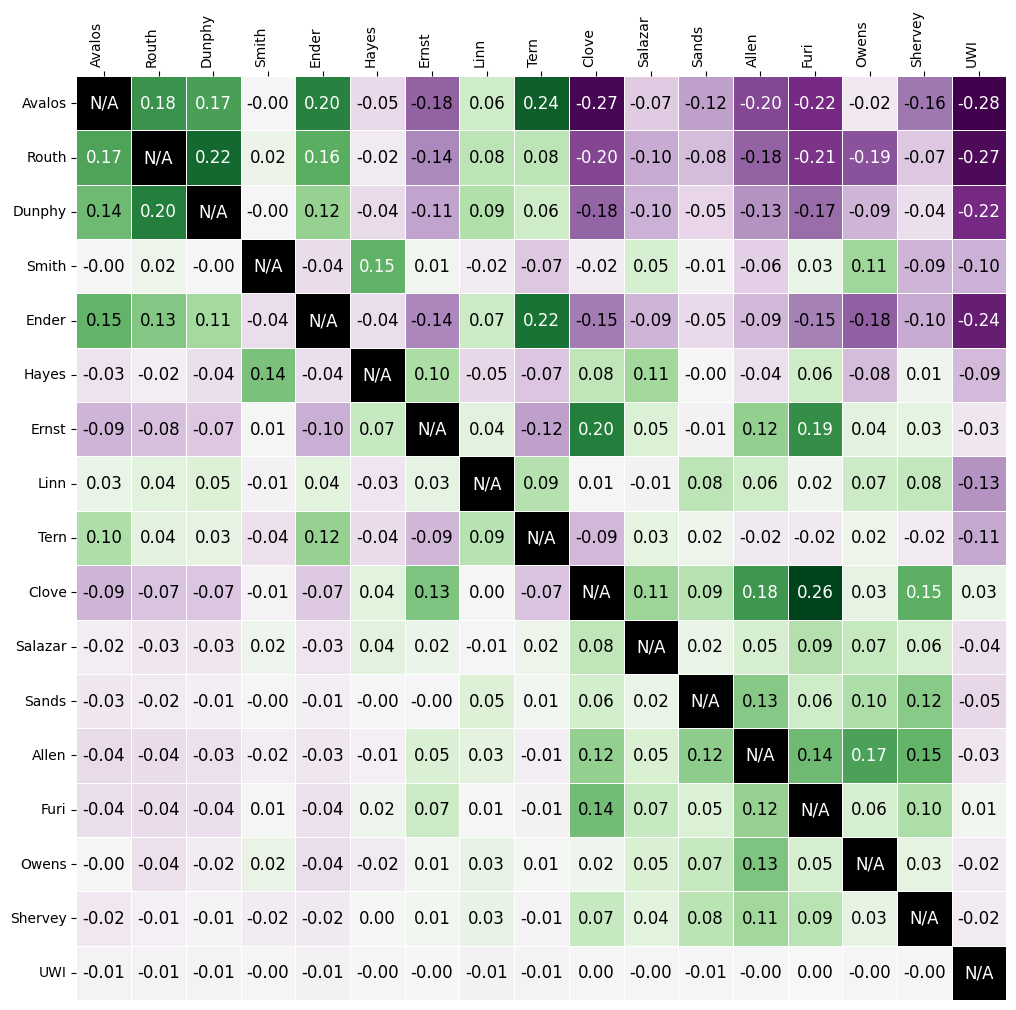

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,12))

ax  = matrix_heatmap(bm, row_labels=all_last_names, 
                        column_labels=all_last_names,
                        row_label_rotation = 0,
                        column_label_rotation = 90,
                        ax = ax,
                        cell_font_size = 12)

The matrix heatmap uses a scale from purple to green, where dark purple means more negative, and dark green means more positive.
Let's examine a few entries.

The (Routh, Dunphy) entry is the largest positive value (0.22). This means that you were 22% more likely to rank Routh on your ballot if you ranked Dunphy. The corresponding entry (Dunphy, Routh) is also strongly positive at 0.20, which means that Routh and Dunphy received support from the same voters.

The (Avalos, Ernst) entry is by far the most negative at -0.18. This means that if you ranked Ernst, you were less likely to rank Avalos. The corresponding entry (Ernst, Avalos) is -0.09, so voters who ranked Avalos were less likely to rank Ernst, although to a lesser degree. This indicates distinct support bases for the two candidates.

Here are the other two matrices, which we will define but not discuss. 

The (i,j) entry of the candidate distance matrix shows the average distance between candidates i and j when i >= j on the same ballot.

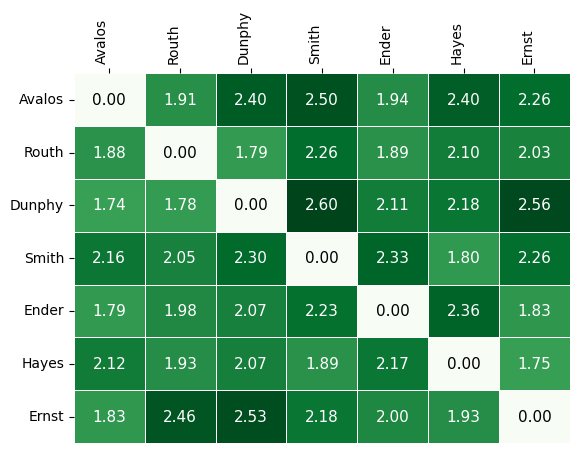

In [26]:
cdm  = candidate_distance_matrix(profile, candidates = viable_cands)

last_names_viable = [name.split(" ")[-1] for name in viable_cands]

ax  = matrix_heatmap(cdm, row_labels=last_names_viable, 
                        column_labels=last_names_viable,
                        row_label_rotation = 0,
                        column_label_rotation = 90)

Finally, the (i,j) entry of the comentions matrix shows the number of times candidates i,j were mentioned on the same ballot with i >= j. There is an option to symmetrize the matrix, which makes the (i,j) entry the number of times that i and j were mentioned on the same ballot (irrespective of position).

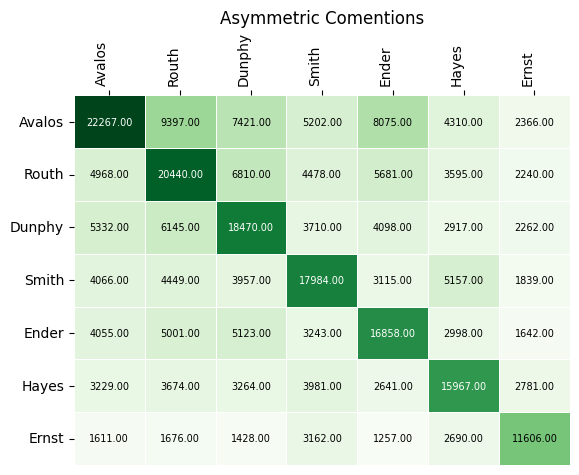

In [27]:
cmm_asym  = comentions_matrix(profile, candidates = viable_cands)
ax  = matrix_heatmap(cmm_asym, row_labels=last_names_viable, 
                        column_labels=last_names_viable,
                        row_label_rotation = 0,
                        column_label_rotation = 90)

plt.title("Asymmetric Comentions") 
plt.show()

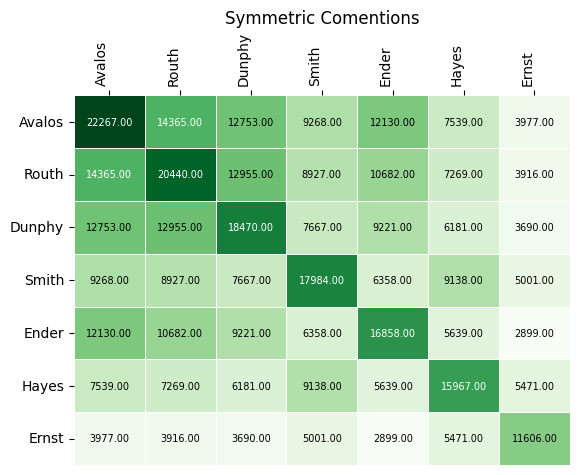

In [28]:
cmm_sym  = comentions_matrix(profile, candidates = viable_cands, symmetric=True)
ax  = matrix_heatmap(cmm_sym, row_labels=last_names_viable, 
                        column_labels=last_names_viable,
                        row_label_rotation = 0,
                        column_label_rotation = 90) 

plt.title("Symmetric Comentions")
plt.show()

## Voter Behavior


### Ballot Length

We can look at the patterns of ballot length, or the
number of candidates ranked. In other real-world ranked choice elections, like Scotland, when voters are ranking candidates to fill m seats, the most
common ballot length is m, and typically the next most common behavior is to rank all available
candidates. It is natural to interpret a ballot ranking exactly m candidates with an expression of the
voter’s preferred winner set.

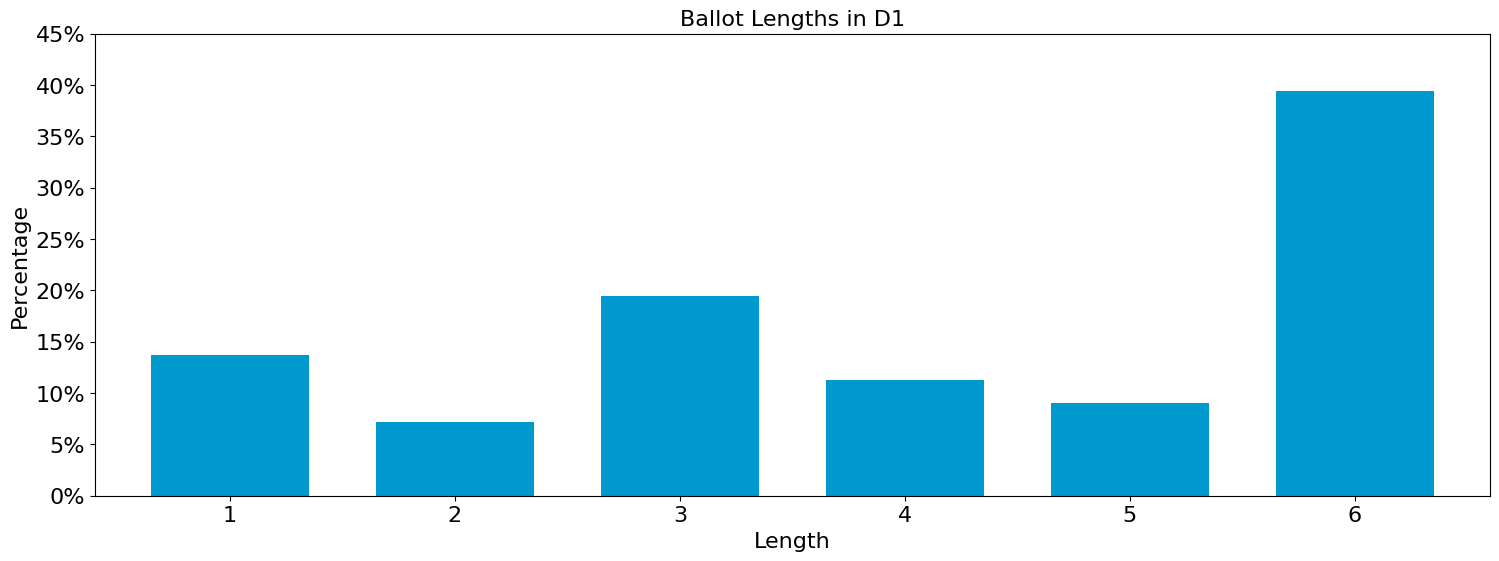

In [29]:
from votekit.plots import profile_ballot_lengths_plot
import matplotlib.pyplot as plt

ax = profile_ballot_lengths_plot(profile, title="Ballot Lengths in D1", normalize=True, y_axis_name="Percentage", x_axis_name="Length")

# change the tick labels to percentages
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f"{float(x.get_text()):.0%}" for x in ax.get_yticklabels()])

plt.show()

Portland D1 voters did a great job casting complete ballots: almost 40% of them were complete, and less than 15% of them were bullet votes for a single person.

Some observers worried that minority communities might be more likely to vote short ballots.
One way to get a vantage point on that is to consider whether ballots with a first-choice vote for a
candidate of color look different in terms of their overall length. However, the identity of the top
choice seems to make no meaningful difference in the ballot length pattern.

We use the self-identified race of each candidate to determine if they are a candidate of color. 4 of the 16 candidates did not identify, and we have chosen to categorize them as non-POC. You can change one line below to categorize them as POC, and note that this does not change the results meaningfully.

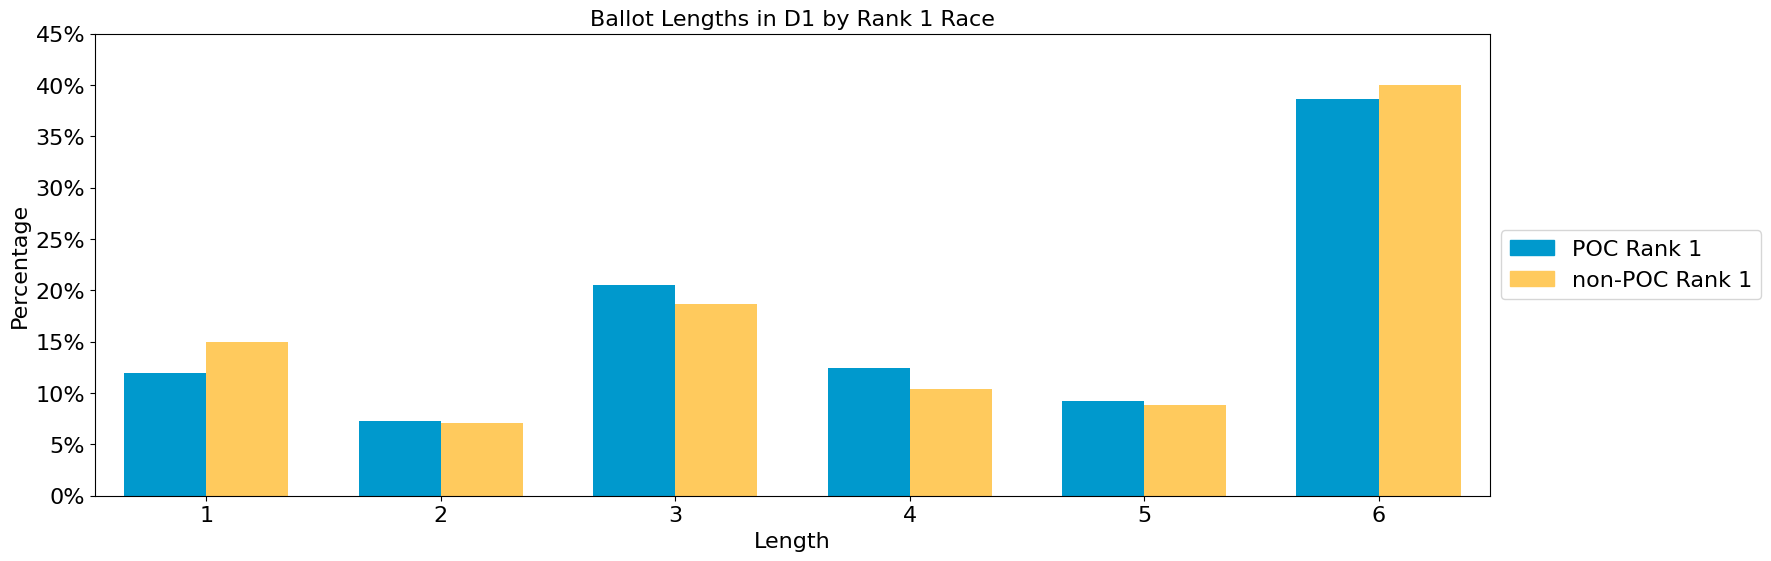

In [30]:
from votekit.pref_profile import PreferenceProfile
from votekit.plots import multi_profile_ballot_lengths_plot

d1_candidate_to_race = {
    'Noah Ernst': 'White',
    'Joe Allen':'White',
    'Terrence Hayes': 'Black',
    'David Linn':'White',
    'Jamie Dunphy': 'White',
    'Steph Routh': 'White',
    'Peggy Sue Owens': 'White',
    'Loretta Smith': 'Black',
    'Timur Ender': 'White',
    'Doug Clove': 'White',
    'Candace Avalos': 'Black/Latina',
    'Cayle Tern': 'Asian'
}

missing_race_classify = "White" # change this to non-White to see how classify the 4 cands with missing race
# differently would change the analysis

w_ballots = [b for b in profile.ballots if d1_candidate_to_race.get(next(iter(b.ranking[0])), missing_race_classify) == "White"]
poc_ballots = [b for b in profile.ballots if d1_candidate_to_race.get(next(iter(b.ranking[0])), missing_race_classify) != "White"]

sub_profile_w = PreferenceProfile(ballots=w_ballots)
sub_profile_poc = PreferenceProfile(ballots = poc_ballots)

ax = multi_profile_ballot_lengths_plot({"POC Rank 1": sub_profile_poc, "non-POC Rank 1": sub_profile_w}, 
                                       show_profile_legend=True, normalize=True,
                                       y_axis_name="Percentage",
                                       title = "Ballot Lengths in D1 by Rank 1 Race",
                                       x_axis_name="Length")

# change the tick labels to percentages
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f"{float(x.get_text()):.0%}" for x in ax.get_yticklabels()])

plt.show()


### Ballot Exhaustion

In a ranked-choice election which unfolds round by round, a ballot is often called exhausted if the
ballot is not used in the final round of meaningful tabulation. Here in District 1, Candace
Avalos crosses threshold in Round 13, and those ranking Avalos first have some surplus weight
transferred to their next choice. Round 15 is the last round of tabulation before the winners are
confirmed, when Dunphy, Hayes, and Smith are still in contention for the two remaining seats.
Thus, in District 1, for a ballot to not be considered exhausted, it must include at least one of these
three candidates. 

In single-winner ranked-choice elections, exhausted ballots are often viewed as
problematic because they do not contribute to the determination of the winner. In the multi-winner
(STV) context, this makes less sense. For example, consider a District 1 voter who bullet-votes for
Avalos versus a voter who bullet-votes for Smith. The former ballot is considered exhausted (be-
cause Avalos is elected early) while the latter is not. But the Avalos bullet voter may be completely
satisfied with the outcome. For this reason, we find it useful to nuance the idea of ballot exhaustion
by offering other, more interpretable measures.

Active rate: How many ballots were still active when the last decision was made?

In [31]:
from votekit.ballot import Ballot

deduplicated_ballots = [Ballot(ranking=b.ranking, weight=1) for b in profile.ballots for _ in range(int(b.weight))]
ballots_with_ids = [Ballot(ranking=b.ranking, voter_set = {f"{i}"}, weight = 1) for i,b in enumerate(deduplicated_ballots)]
profile_with_ids = PreferenceProfile(ballots=ballots_with_ids)
election_with_ids = STV(profile_with_ids, m=3)

initial_ballot_count = profile.total_ballot_wt

final_profile = election_with_ids.get_profile(14)

remaining_voters = [voter for b in final_profile.ballots for voter in b.voter_set]
remaining_count = len(remaining_voters)

print(f"The active rate is {remaining_count/initial_ballot_count:.1%}.")

The active rate is 77.0%.


STV exhaustion rate: How many ballots ranked fewer than six candidates, and did not include
any winner or the last candidate eliminated?

Futility rate: How many ballots ranked six candidates, but did not include any winner or the last candidate eliminated?

In [32]:
stv_exhausted = 0
futile = 0

winners = [c for s in election.get_elected() for c in s]
last_cand_elim = election.get_eliminated()[0]

relevant_cands = last_cand_elim.union(winners)

for ballot in profile.ballots:
    num_ranked = len(ballot.ranking)

    ranked_cands = [c for s in ballot.ranking for c in s]
    num_ranked_rel_cands = len(relevant_cands.intersection(ranked_cands))

    if num_ranked_rel_cands == 0:

        if num_ranked < 6:
            stv_exhausted+= ballot.weight
        elif num_ranked == 6:
            futile += ballot.weight



print(f"The STV exhaustion rate in D1 is {stv_exhausted/initial_ballot_count:.1%}.")
print(f"The futility rate in D1 is {futile/initial_ballot_count:.1%}.")


The STV exhaustion rate in D1 is 12.6%.
The futility rate in D1 is 1.4%.


## Comparing to other systems

### R-Representation Scores

The r-representation score is a measure of how satisfied the voters are. Given a set of candidates, the r-represenation score of a profile is the proportion of voters who ranked at least one of the candidates in one of the top-r positions of their ballot. Common choices for r include 1, the number of seats, and the maximum length of a ballot.

Let's explore these scores for the STV election in Portland, and see how they differ across other choices of election system.

In [33]:
from votekit.representation_scores import r_representation_score, winner_sets_r_representation_scores

stv_winners = [c for s in election.get_elected() for c in s]
stv_1_representation = r_representation_score(profile, r=1, candidate_list=stv_winners)
stv_3_representation = r_representation_score(profile, r=3, candidate_list=stv_winners)
stv_6_representation = r_representation_score(profile, r=6, candidate_list=stv_winners)

print(f"STV 1-representation score for {stv_winners}: {stv_1_representation:.1%}")
print(f"STV 3-representation score for {stv_winners}: {stv_3_representation:.1%}")
print(f"STV 6-representation score for {stv_winners}: {stv_6_representation:.1%}")

STV 1-representation score for ['Candace Avalos', 'Loretta Smith', 'Jamie Dunphy']: 44.2%
STV 3-representation score for ['Candace Avalos', 'Loretta Smith', 'Jamie Dunphy']: 70.9%
STV 6-representation score for ['Candace Avalos', 'Loretta Smith', 'Jamie Dunphy']: 79.6%


So almost 80% of the voters have some winner listed somewhere on their ballot. That is pretty high satisfaction!
Let's compare that to a few other election systems.

In [34]:
from votekit.elections import CondoBorda, Plurality, Borda


alt_elections = {"Condorcet": CondoBorda(profile, m=3),
                 "Borda": Borda(profile, m=3),
                 "Plurality": Plurality(profile, m=3),
                 }

for e_name, e in alt_elections.items():
    print(e_name)
    e_winners = [c for s in e.get_elected() for c in s]
    e_1_representation = r_representation_score(profile, r=1, candidate_list=e_winners)
    e_3_representation = r_representation_score(profile, r=3, candidate_list=e_winners)
    e_6_representation = r_representation_score(profile, r=6, candidate_list=e_winners)

    print(f"{e_name} 1-representation score for {e_winners}: {e_1_representation:.1%}")
    print(f"{e_name} 3-representation score for {e_winners}: {e_3_representation:.1%}")
    print(f"{e_name} 6-representation score for {e_winners}: {e_6_representation:.1%}")
    print("\n----------------------------\n")

Condorcet
Condorcet 1-representation score for ['Candace Avalos', 'Steph Routh', 'Jamie Dunphy']: 40.2%
Condorcet 3-representation score for ['Candace Avalos', 'Steph Routh', 'Jamie Dunphy']: 63.6%
Condorcet 6-representation score for ['Candace Avalos', 'Steph Routh', 'Jamie Dunphy']: 72.9%

----------------------------

Borda
Borda 1-representation score for ['Candace Avalos', 'Steph Routh', 'Loretta Smith']: 41.5%
Borda 3-representation score for ['Candace Avalos', 'Steph Routh', 'Loretta Smith']: 71.0%
Borda 6-representation score for ['Candace Avalos', 'Steph Routh', 'Loretta Smith']: 79.5%

----------------------------

Plurality
Plurality 1-representation score for ['Candace Avalos', 'Loretta Smith', 'Jamie Dunphy']: 44.2%
Plurality 3-representation score for ['Candace Avalos', 'Loretta Smith', 'Jamie Dunphy']: 70.9%
Plurality 6-representation score for ['Candace Avalos', 'Loretta Smith', 'Jamie Dunphy']: 79.6%

----------------------------



We can also see who the most representative winner set would have been.

In [35]:
for r in [1,3,6]:
    winner_sets_score_dict = winner_sets_r_representation_scores(profile, m=3, r=r)
    winner_sets_score_tuples = [(set(k),v) for k,v in winner_sets_score_dict.items()]
    sorted_winner_sets = sorted(winner_sets_score_tuples, reverse=True, key= lambda x: x[1])

    print(f'{r}-representation winner sets, top 5 most representative')
    for winner_set, score in sorted_winner_sets[:5]:
        print(winner_set, f"{score:.1%}")
    print("\n--------------------\n")


1-representation winner sets, top 5 most representative
{'Candace Avalos', 'Jamie Dunphy', 'Loretta Smith'} 44.2%
{'Noah Ernst', 'Candace Avalos', 'Loretta Smith'} 41.8%
{'Terrence Hayes', 'Candace Avalos', 'Loretta Smith'} 41.7%
{'Candace Avalos', 'Steph Routh', 'Loretta Smith'} 41.5%
{'Candace Avalos', 'Timur Ender', 'Loretta Smith'} 40.7%

--------------------

3-representation winner sets, top 5 most representative
{'Noah Ernst', 'Candace Avalos', 'Loretta Smith'} 74.8%
{'Terrence Hayes', 'Candace Avalos', 'Loretta Smith'} 72.9%
{'Noah Ernst', 'Candace Avalos', 'Steph Routh'} 71.4%
{'Terrence Hayes', 'Candace Avalos', 'Noah Ernst'} 71.3%
{'Terrence Hayes', 'Candace Avalos', 'Steph Routh'} 71.1%

--------------------

6-representation winner sets, top 5 most representative
{'Noah Ernst', 'Candace Avalos', 'Loretta Smith'} 82.8%
{'Terrence Hayes', 'Candace Avalos', 'Loretta Smith'} 81.0%
{'Candace Avalos', 'Doug Clove', 'Loretta Smith'} 80.3%
{'Terrence Hayes', 'Candace Avalos', 'Noa

Notice that Ernst, Avalos, Smith would actually be a more represenative set under some choices of r than Dunphy, Avalos, Smith.
STV does not choose Ernst however because many of the votes for Ernst were bullet votes, and thus lose information when he is eliminated.